### VGG16

Paper: https://arxiv.org/abs/1409.1556

In [ ]:
# imports
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [ ]:
n_epochs = 5
input_dim = 32               # found the dimensions from the dataset using print(data.shape)
output_classes = 10          # Checked for distinct labels in dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #setting torch device

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                                  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes the tensor
])

train_dataset = datasets.CIFAR100(root='./data', train=True,                       # To download the CIFAR-10 dataset
                                             download=True, transform=transform)

test_dataset = datasets.CIFAR100(root='./data', train=False,                       # Load CIFAR-10 test dataset
                                             download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,          # Define data loaders to load data in batches
                                             shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                             shuffle=False)


100%|██████████| 169M/169M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


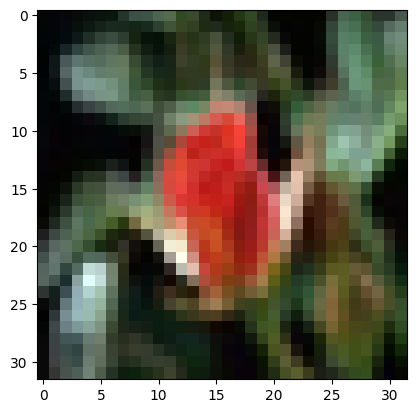

Label: 70


In [ ]:
import matplotlib.pyplot as plt

def imshow(img):                             # Define a function to display an image
    img = img / 2 + 0.5                      # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a random image from the dataset
idx = 41452
image, label = train_dataset[idx]

# Display the image
imshow(image)
print('Label:', label)


In [ ]:
import torch
import torch.nn as nn

class VGG16_Small(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16_Small, self).__init__()
        # Input size: 32x32x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        # Output: 32x32x64

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Output: 16x16x64

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        # Output: 16x16x128

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Output: 8x8x128

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        # Output: 8x8x256

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        # Output: 8x8x256

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Output: 4x4x256

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        # Output: 4x4x512

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        # Output: 4x4x512

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Output: 2x2x512

        # Removed layers 11-13 as the feature map is already quite small

        # Adjusted the input size of the first FC layer to match the new feature map size
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*2*512, 4096),  # Changed from 7*7*512
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = out.reshape(out.size(0), -1)  # Flattening to (batch_size, 2*2*512)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Model initialization and optimizer setup
vgg16_small = VGG16_Small()
optimizer = torch.optim.Adam(vgg16_small.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
# Defining one epoch of training
def train(model, train_loader, optimizer=optimizer, loss=loss_fn):
    # We train the appropriate model with the input data and the appropriate optimizer
    # ps is how often we print the accuracy

    model=model.to(device)

    train_iter = iter(train_loader)
    model.train()
    # Puts model in train mode
    total_loss = 0.0
    for i, (data, targets) in tqdm(enumerate(train_iter)):
        # i is iteration, data = 1 mini batch of images, targets = 1 mini batch target values
        # This repeats for all mini batches

        data=data.to(device)
        targets=targets.to(device)

        optimizer.zero_grad()  # Ensures gradients stored in optimizer are reset before each backward pass

        outputs = model.forward(data) # Forward pass

        loss_val = loss(outputs, targets) # Loss computation
        loss_val.backward() # Backward pass
        optimizer.step() # Backward pass
        total_loss += loss_val.item()
    return total_loss


In [ ]:
for i in range(n_epochs):
  loss = train(vgg16_small, train_loader)
  print(f'Epoch {i+1}: Loss {loss}')

391it [00:35, 11.14it/s]


Epoch 1: Loss 1681.914889574051


391it [00:33, 11.58it/s]


Epoch 2: Loss 1548.9028754234314


391it [00:33, 11.60it/s]


Epoch 3: Loss 1425.6431031227112


391it [00:33, 11.57it/s]


Epoch 4: Loss 1305.8948061466217


391it [00:33, 11.65it/s]

Epoch 5: Loss 1194.7281033992767


In [ ]:
def accuracy(model, test):
    # Evaluate a model given a test loader
    model.to(device)
    model.eval()
    with torch.no_grad():
        count = 0
        correct = 0
        for data, targets in iter(test):
            data = data.to(device)
            targets = targets.to(device)
            outputs = model.forward(data)
            predicted = outputs.max(1)[1] # Maximum output is predicted class
            count += len(targets) # Total length of datasets
            correct += (predicted == targets.to(device)).sum().item()
            # This gives a tensor of True and False values and adds no. of True values to correct each iteration
        accuracy = correct/count
        return accuracy

In [ ]:
cnn_acc_test = (accuracy(vgg16_small, test_loader))
cnn_acc_train = (accuracy(vgg16_small, train_loader))
print(
    f'''
    Accuracy on test dataset for CNN is {cnn_acc_test*100: .2f}%.
    Accuracy on train datset for CNN is {cnn_acc_train*100: .2f}%.
    '''
)


    Accuracy on test dataset for CNN is  25.17%.
    Accuracy on train datset for CNN is  26.47%.
    


### Resnet

Paper: https://arxiv.org/abs/1512.03385

In [ ]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [ ]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [ ]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)


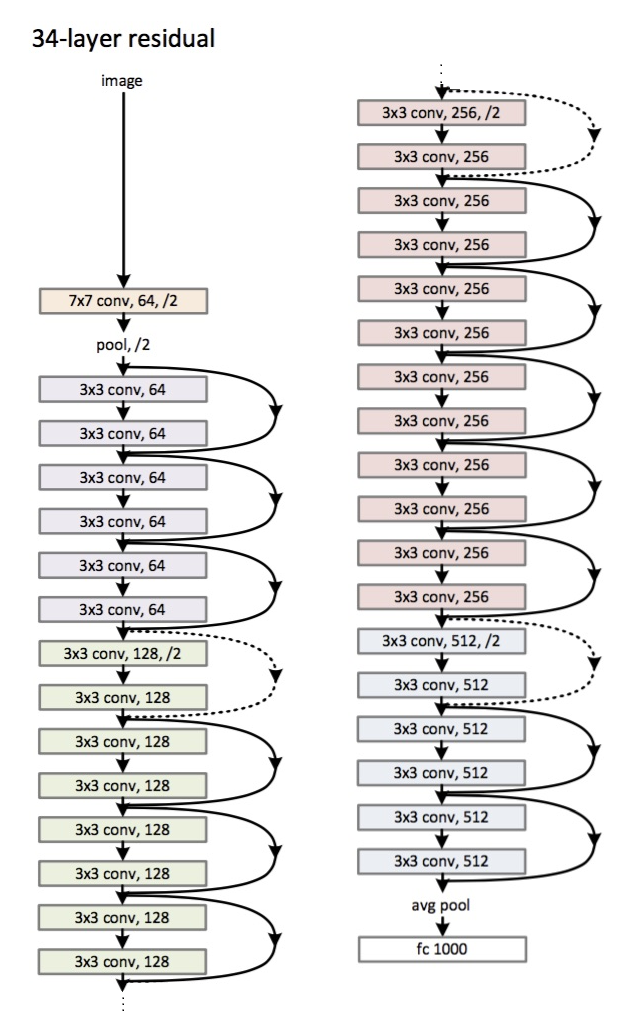

In [ ]:
!pip install torchinfo -q

In [ ]:
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
├─MaxPool2d: 1-2                         [1, 64, 56, 56]           --
├─Sequential: 1-3                        [1, 64, 56, 56]           --
│    └─ResidualBlock: 2-4                [1, 64, 56, 56]           --
│    │    └─Sequential: 3-1              [1, 64, 56, 56]           37,056
│    │    └─Sequential: 3-2              [1, 64, 56, 56]           37,056
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    └─ResidualBlock: 2-5                [1, 64, 56, 56]           --
│    │    └─Sequential: 3-4              [1, 64, 56, 56]           37,056

In [ ]:
import torchvision
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=28),  # Add padding for random crops
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data_CIFAR10',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data_CIFAR10',
    train=False,
    download=True,
    transform=test_transform
)

batch_size = 64
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Extracting ./data_CIFAR10/cifar-10-python.tar.gz to ./data_CIFAR10
Files already downloaded and verified


In [ ]:
def train_model(model, criterion, optimizer, train_loader, test_loader,
                num_epochs=10, device='cuda'):
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Evaluation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs = 10, device = device)

Epoch 1/10
----------


 41%|████      | 322/782 [02:23<03:28,  2.20it/s]

### Transfer Learning

Loading a [pretrained resnet34 model](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html)

In [ ]:
import torchvision.models as models
model = models.resnet34(pretrained=True)
model

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

In [ ]:
147.61*128/1000

In [ ]:
model.fc

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Linear(512, 10)

In [ ]:
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
model = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs = 5, device = device)